In [1]:
import numpy as np
import cv2
from skimage.feature import hog
%matplotlib inline
from project_functions import *

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
from scipy.ndimage.measurements import label

In [93]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, show_boxes):
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_colorspace(img_tosearch, color_space=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or show_boxes is True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                top_left = (xbox_left, ytop_draw+ystart)
                bottom_right = (xbox_left+win_draw,ytop_draw+win_draw+ystart)
                boxes.append((top_left, bottom_right))
    return boxes

In [144]:
def add_heat(heatmap, bbox_list, weight):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += weight

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



In [57]:

cur_image = None

In [166]:

dist_pickle = pickle.load( open("data/svc_pickle_color_off.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

hog_channel = dist_pickle['hog_channel']
color_space = dist_pickle['color_space']

def process_image(image):
    global cur_image
    cur_image = image
    
    boxes_0 = find_cars(image, 370, 520, 1, svc, X_scaler, orient, pix_per_cell, 
                        cell_per_block, spatial_size, hist_bins, color_space, False)
#     boxes_1 = find_cars(image, 400, 550, 1, svc, X_scaler, orient, pix_per_cell, 
#                         cell_per_block, spatial_size, hist_bins, color_space, False)
    boxes_2 = find_cars(image, 390, 550, 1.5, svc, X_scaler, orient, pix_per_cell, 
                        cell_per_block, spatial_size, hist_bins, color_space, False)
    boxes_3 = find_cars(image, 380, 650, 2, svc, X_scaler, orient, pix_per_cell, 
                        cell_per_block, spatial_size, hist_bins, color_space, False)
    boxes_4 = find_cars(image, 410, 680, 2.5, svc, X_scaler, orient, pix_per_cell, 
                        cell_per_block, spatial_size, hist_bins, color_space, False)
    boxes_5 = find_cars(image, 400, 700, 3, svc, X_scaler, orient, pix_per_cell, 
                        cell_per_block, spatial_size, hist_bins, color_space, False)
    box_list = boxes_2 + boxes_3 + boxes_4 + boxes_5 + boxes_0
    
    
#     heat = np.zeros_like(image[:,:,0]).astype(np.float)

#     # Add heat to each box in box list
#     heat = add_heat(heat,box_list)

#     # Apply threshold to help remove false positives
#     heat = apply_threshold(heat,1)

#     # Visualize the heatmap when displaying    
#     heatmap = np.clip(heat, 0, 255)

#     # Find final boxes from heatmap using label function
#     labels = label(heatmap)
#     draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    
    # add detections to the history
    rectangles = box_list
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(image[:,:,0]).astype(np.float)
#     cur_thresh = 0
    for idx, rect_set in enumerate(reversed(det.prev_rects)):
        heatmap_img = add_heat(heatmap_img, rect_set, 1)
#         cur_thresh += 1/(idx+1);
    heatmap_img = apply_threshold(heatmap_img, len(det.prev_rects) + 4)
#     heatmap_img = apply_threshold(heatmap_img, cur_thresh+2)
     
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img




# MAKE SURE TO SHRINK THE IMAGE DOWN TO THE TEST IMAGE SIZE OTHERWISE BOXES WILL BE SMALL AND IT WILL TAKE A LONG TIME


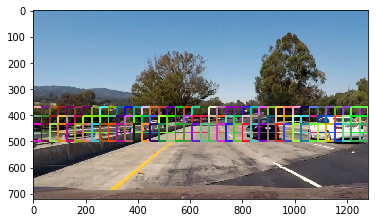

In [107]:

def draw_boxes(img, boxes, random_color=True):
    img = img.astype(np.float32)/255
    draw_img = np.copy(img)
    for (top_left, bot_right) in boxes:
        if random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        else:
            color = (0,0,255)
        cv2.rectangle(draw_img,tuple(top_left),tuple(bot_right),color,6) 
    return draw_img

test_image = cur_image
boxes_0 = find_cars(test_image, 370, 520, 1, svc, X_scaler, orient, pix_per_cell, 
                    cell_per_block, spatial_size, hist_bins, color_space, True)
boxes_1 = find_cars(test_image, 400, 550, 1, svc, X_scaler, orient, pix_per_cell, 
                    cell_per_block, spatial_size, hist_bins, color_space, True)
boxes_2 = find_cars(test_image, 390, 550, 1.5, svc, X_scaler, orient, pix_per_cell, 
                    cell_per_block, spatial_size, hist_bins, color_space, True)
boxes_3 = find_cars(test_image, 380, 650, 2, svc, X_scaler, orient, pix_per_cell, 
                    cell_per_block, spatial_size, hist_bins, color_space, True)
boxes_4 = find_cars(test_image, 410, 680, 2.5, svc, X_scaler, orient, pix_per_cell, 
                    cell_per_block, spatial_size, hist_bins, color_space, True)
boxes_5 = find_cars(test_image, 400, 700, 3, svc, X_scaler, orient, pix_per_cell, 
                    cell_per_block, spatial_size, hist_bins, color_space, True)
boxes = boxes_1 + boxes_2 + boxes_3 + boxes_0
out_img = draw_boxes(test_image, boxes_0, True)

# plt.imshow(cur_image)
plt.imshow(out_img)
# plt.imshow(process_image(test_image))

In [164]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 20:
            # throw out oldest rectangle set(s)
#             self.prev_rects = self.prev_rects[len(self.prev_rects)-20:]
            self.prev_rects.pop(0)

### VIdeo

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [168]:
det = Vehicle_Detect()
output = 'output_video/project_video_hsv_test_2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("project_video.mp4").subclip(0,3)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_video/project_video_hsv_test_2.mp4
[MoviePy] Writing video output_video/project_video_hsv_test_2.mp4



  2%|▏         | 24/1261 [00:10<09:28,  2.18it/s]


KeyboardInterrupt: 

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [15]:
cur_image.shape

(720, 1280, 3)

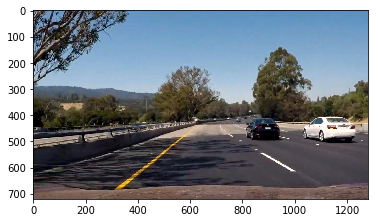

In [81]:
time = .9
frame_file = 'test_images/project_video/'+str(time)+'.jpg'
clip1.save_frame(frame_file, t=time)
plt.imshow(mpimg.imread(frame_file))